# Using physics informed neural networks (PINNs) to solve parabolic PDEs

### Gustavo Henrique do Nascimento (14249084) --- Marcelo Marcelo Baccaro (8989262)

In this notebook, we illustrate physics informed neural networks (PINNs) to solve partial differential equations (PDEs) as proposed in ([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)) with the 1-D Buckley-Leverett ([Fuks et al., 2020](https://doi.org/10.1615/JMachLearnModelComput.2020033905)) as exemple.

## 1) Introduction

We describe the PINN approach for approximating the solution $u:[0,T] \times \mathcal{D} \to \mathbb{R}$ of an evolution equation

$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$

where $\mathcal{N}$ is a nonlinear differential operator acting on $u$, 
$\mathcal{D} \subset \mathbb{R}^d$ a bounded domain,
$T$ denotes the final time and
$u_0: \mathcal{D} \to \mathbb{R}$ the prescribed initial data.
Although the methodology allows for different types of boundary conditions, we restrict our discussion to the inhomogeneous Dirichlet case and prescribe

$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$

where $\partial \mathcal{D}$ denotes the boundary of the domain $\mathcal{D}$ and $u_b: (0,T] \times \partial \mathcal{D} \to \mathbb{R}$ the given boundary data.

### 1.1) Methodology

The method constructs a neural network approximation

$$
u_\theta(t,x) \approx u(t,x)
$$

of the solution of nonlinear PDE, where $u_\theta :[0,T] \times \mathcal{D} \to \mathbb{R}$ denotes a function realized by a neural network with parameters $\theta$.

The continuous time approach for the parabolic PDE as described in ([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)) is based on the (strong) residual of a given neural network approximation $u_\theta \colon [0,T] \times \mathcal{D} \to \mathbb{R} $ of the solution $u$, i.e.,

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

To incorporate this PDE residual $r_\theta$ into a loss function to be minimized, PINNs require a further differentiation to evaluate the differential operators $\partial_t u_\theta$ and $\mathcal{N}[u_\theta]$.
Thus the PINN term $r_\theta$ shares the same parameters as the original network $u_\theta(t,x)$, but respects the underlying "physics" of the nonlinear PDE.
Both types of derivatives can be easily determined through automatic differentiation with current state-of-the-art machine learning libraries, e.g., TensorFlow or PyTorch.

The PINN approach for the solution of the initial and boundary value problem now proceeds by minimization of the loss functional

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

where $X$ denotes the collection of training data and the loss function $\phi_\theta$ contains the following terms:

  - the mean squared residual
$$
  \begin{align*}
   \phi_\theta^r(X^r) := \frac{1}{N_r}\sum_{i=1}^{N_r} \left|r_\theta\left(t_i^r, x_i^r\right)\right|^2
\end{align*}
$$
in a number of collocation points $X^r:=\{(t_i^r, x_i^r)\}_{i=1}^{N_r} \subset (0,T] \times \mathcal{D}$, where $r_\theta$ is the physics-informed neural network,
  - the mean squared misfit with respect to the initial and boundary conditions
$$
    \begin{align*}
   \phi_\theta^0(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|u_\theta\left(t_i^0, x_i^0\right) - u_0\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \phi_\theta^b(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|u_\theta\left(t_i^b, x_i^b\right) - u_b\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}
$$
in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $u_\theta$ is the neural network approximation of the solution $u\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.

Note that the training data $X$ consists entirely of time-space coordinates.


### 1.2) Example: Buckley-Leverett equation

To illustrate the PINN approach we consider the one-dimensional Buckley-Leverett equation on the spatial domain $\mathcal{D} = [0,1]$ with non-convex flux:

$$
\begin{aligned}
    \partial_t u + \dfrac{2 M u (1-u)}{((M+1)u^2-2u+1)^2} \cdot \partial_x u &= 0, \quad &&\quad (t,x) \in (0,1] \times (0,1),\\
   u(0,x) &= 0,                 \quad &&\quad x \in [0,1],\\
   u(t,0) &= 1,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

This PDE arises in various disciplines such as two-phase transport with nonlinear mass conservation, see 
([Fuks et al., 2020](https://doi.org/10.1615/JMachLearnModelComput.2020033905)).

## 2) PINN (Physics-Informed Neural Network) without diffusive term

Let's begin with numerically solving the 1-D Buckley-Leverett with a PINN that doesn't have a convergence element like a diffusive term.

### 2.1) Import necessary packages and set problem specific data

As always, Python uses a lot of libraries and pre-defined functions.

In [247]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
M = 1

# Define initial condition
def fun_u_0(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.ones((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + (2*M*u*(1-u)/((M+1)*u**2-2*u+1)**2)*u_x

### 2.2) Generate a set of collocation points

We assume that the collocation points $X_r$ as well as the points for the initial time and boundary data $X_0$ and $X_b$ are generated by random sampling from a uniform distribution.
Although uniformly distributed data are sufficient in our experiments, the authors of
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561))
employed a space-filling Latin hypercube sampling strategy ([Stein, 1987](https://www.tandfonline.com/doi/abs/10.1080/00401706.1987.10488205)).
This strategy slightly improves the observed convergence rate, but for simplicity the code example employ uniform sampling throughout.
We choose training data of size $N_0 = N_b = 300$ and $N_f=10000$.

In [248]:
# Set number of data points
N_0 = 300 # initial
N_b = 300 # boundary
N_r = 10000 # residual

# Set boundary
tmin = 0.
tmax = 1.
xmin = 0.
xmax = 1.

lb = tf.constant([tmin, xmin], dtype=DTYPE) # Lower bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE) # Upper bounds
tf.random.set_seed(0) # random seed

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)
u_0 = fun_u_0(x_0) # intitial condition at x_0

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
X_b = tf.concat([t_b, x_b], axis=1)
u_b = fun_u_b(t_b, x_b) # boundary condition at (t_b,x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

Next, we illustrate the collocation points (red dots) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

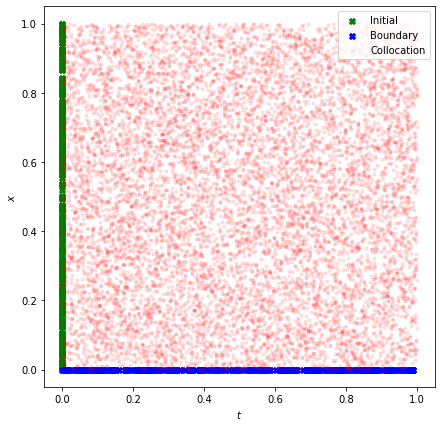

In [249]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
plt.scatter(t_0, x_0, c='g', marker='X', vmin=-1, vmax=1, label='Initial')
plt.scatter(t_b, x_b, c='b', marker='X', vmin=-1, vmax=1, label='Boundary')
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1, label='Collocation')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x$');

### 2.3) Set up network architecture

In this example, adopted from 
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with $3021$ trainable parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; seven intermediate layers: each $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).

In [250]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()
    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'), # tanh activation function
            kernel_initializer='glorot_normal'))
    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    return model

### 2.4) Define routines to determine loss and gradient

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x)
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow. For the 1-D Buckley-Leverett equation, this entails computing $\partial_t u_\theta$ and $\partial_x u_\theta$. In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [251]:
def get_r(model, X_r):
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]
        # Variables t and x are watched during tape to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)
        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))
        # Compute gradient u_x within the GradientTape since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
    del tape
    return fun_r(t, x, u, u_t, u_x, u_xx)

The next function computes the loss for our model

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `u_data = [u_0, u_b]`.

In [252]:
def compute_loss(model, X_r, X_data, u_data):
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    # Initialize loss
    loss = phi_r
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    return loss

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [253]:
def get_grad(model, X_r, X_data, u_data):
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)
    g = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, g

### 2.5) Set up optimizer and train model

Next we initialize the model, set the learning rate to $l_r=0.001$. Train the model for $N=2000$ epochs. Here, we set up a function `train_step()` which performs one training step.

In [254]:
model = init_model()
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(model):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

N_epoch = 2000 # Number of training epochs
hist = []
for i in range(N_epoch+1):
    loss = train_step(model)
    # Append current loss to hist
    hist.append(loss.numpy())

### 2.6) Plot solution & evolution of loss

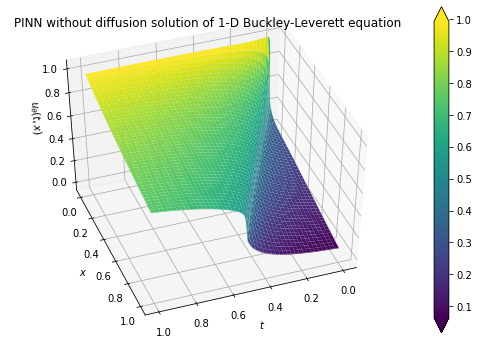

In [255]:
from mpl_toolkits.mplot3d import Axes3D
# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N+1)
xspace = np.linspace(lb[1], ub[1], N+1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T
# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))
# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(45,70) # view angle
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_zlim(-0.05,1.05)
ax.set_title('PINN without diffusion solution of 1-D Buckley-Leverett equation')
plt.colorbar(p, ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], extend='both');

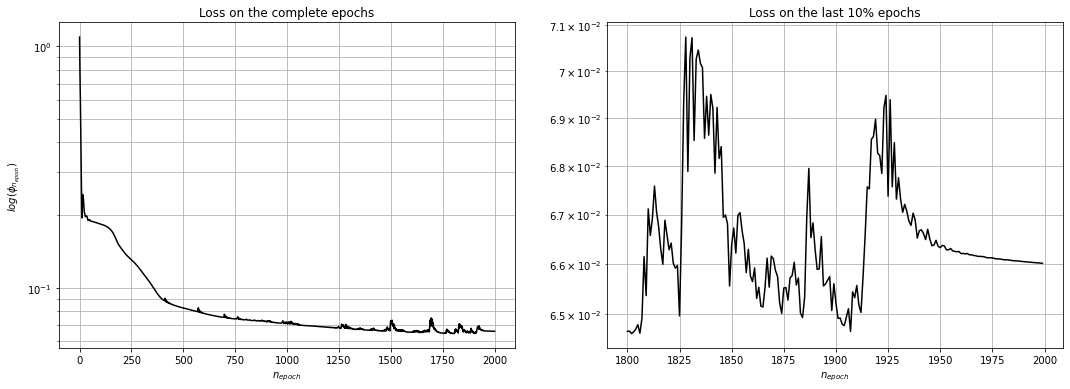

In [256]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(121) # complete plot
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$log(\\phi_{n_{epoch}})$')
plt.grid(True, which ="both")
plt.title('Loss on the complete epochs')
ax = fig.add_subplot(122) # last 90%
N_epoch_90 = round(0.9*N_epoch)
hist90 = hist[N_epoch_90:N_epoch]
ax.semilogy(np.arange(N_epoch_90,N_epoch), hist90,'k-')
ax.set_xlabel('$n_{epoch}$')
plt.grid(True, which ="both")
plt.title('Loss on the last 10% epochs');

### 2.7) Comparison between the PINN solution without diffusive term and the analytical solution

The analytical solution of 1-D Buckley-Leverett can be obtained following the method from this paper ([Karni, 2011](https://www.taylorfrancis.com/chapters/edit/10.1201/b18130-5/nonlinear-hyperbolic-conservation-laws%E2%80%94a-brief-informal-introduction-karni)), which is available [here](https://dept.math.lsa.umich.edu/~karni/m671/Toro65.pdf). With algebra knowledge, one may reach the analytical solution:

$$v(\xi) = \frac{1}{2} + \sqrt{\frac{1}{2} \sqrt{\left(1+\frac{1}{2\xi}\right)^2-1} -\frac{1}{4} -\frac{1}{4\xi}}$$

where $u(t,x)=v(x/t)=v(\xi) \in [0,1]$. The boundaries conditions imply that $\xi_1 = 0$ and $\xi_2 = a(u_s) \approx 1.207$, where $u_s = \sqrt{0,5} \approx 0.707$ is the shock value.

For comparison porpuse, let's see what happens at the instants 0.25, 0.5 and 0.75 with the analytical solution.

In [257]:
us = np.sqrt(0.5) # saturação de shock
xi_s = 2*us*(1-us) / (2*us**2 -2*us +1)**2 # xi shock
ts = np.array([0.25, 0.5, 0.75]) # time sample
xs = ts * xi_s # shock position
x_step = 1e-3 # passo em x

x1 = np.arange(x_step, xs[0], x_step)
t1 = ts[0]
xi1 = x1 / t1
u1 = 0.5 + np.sqrt(np.sqrt((1+0.5/xi1)**2-1)/2 -0.25 -0.25/xi1)
x1 = np.append([[0]], x1) # ajuste do vetor x1
x1 = np.append(x1, [[xs[0],1]])
u1 = np.append([[1]], u1) # ajuste do vetor u1
u1 = np.append(u1, [[0,0]])

x2 = np.arange(x_step, xs[1], x_step)
t2 = ts[1]
xi2 = x2 / t2
u2 = 0.5 + np.sqrt(np.sqrt((1+0.5/xi2)**2-1)/2 -0.25 -0.25/xi2)
x2 = np.append([[0]], x2) # ajuste do vetor x2
x2 = np.append(x2, [[xs[1],1]])
u2 = np.append([[1]], u2) # ajuste do vetor u2
u2 = np.append(u2, [[0,0]])

x3 = np.arange(x_step, xs[2], x_step)
t3 = ts[2]
xi3 = x3 / t3
u3 = 0.5 + np.sqrt(np.sqrt((1+0.5/xi3)**2-1)/2 -0.25 -0.25/xi3)
x3 = np.append([[0]], x3) # ajuste do vetor x3
x3 = np.append(x3, [[xs[2],1]])
u3 = np.append([[1]], u3) # ajuste do vetor u3
u3 = np.append(u3, [[0,0]]);

And the curves of the PINN solution without diffusion at the instants 0.25, 0.5 and 0.75:

In [258]:
pt1 = np.where(tspace==t1)[0]
u1_PINN = U[:,pt1]
pt2 = np.where(tspace==t2)[0]
u2_PINN = U[:,pt2]
pt3 = np.where(tspace==t3)[0]
u3_PINN = U[:,pt3]

Ploting both at the instants 0.25, 0.5 and 0.75:

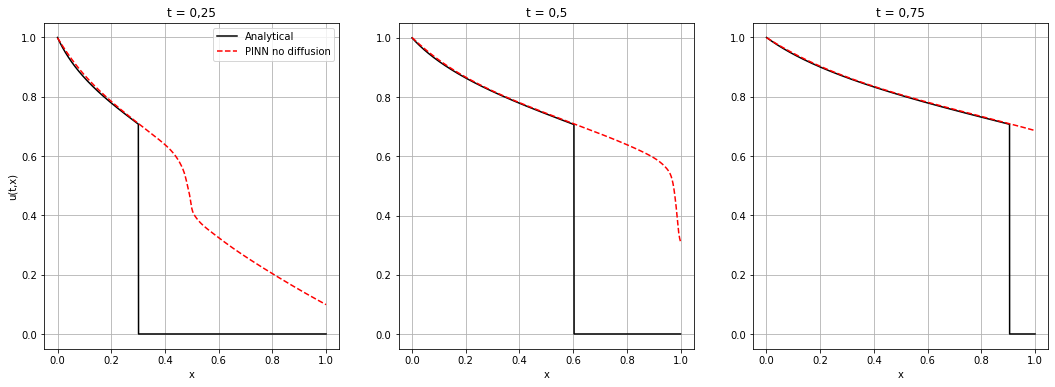

In [259]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(x1, u1, 'k', label='Analytical')
plt.plot(xspace, u1_PINN, 'r--', label='PINN no diffusion')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('t = 0,25')
plt.legend()
plt.grid(True)

plt.subplot(132)
plt.plot(x2, u2, 'k')
plt.plot(xspace, u2_PINN, 'r--')
plt.xlabel('x')
plt.title('t = 0,5')
plt.grid(True)

plt.subplot(133)
plt.plot(x3, u3, 'k')
plt.plot(xspace, u3_PINN, 'r--')
plt.xlabel('x')
plt.title('t = 0,75')
plt.grid(True)

plt.show();

These graphs show how terrible the PINN model predicts without the diffusive term. So, is it always like that? Are PINNs worthless? No!! PINNs do fine when the solution is continuous, and not necesserally smooth. But, in this exemple, the solution isn't continuous because of the **mathematical shock** between the two phases. Fortunately, there's a cure!!

## 3) PINN with diffusive term

As the title indicates, a diffusive term can fix the convergence of the PINN. This element is just $ϵ ⋅ ∂_{xx} u$, where $ϵ>0$ is a scalar diffusion coefficient that represents the inverse of the Péclet number, Pe – the ratio of a characteristic time for dispersion to a characteristic time for convection.

The core ideia is use the vanishing viscosity method for solving the initial value problems for hyperbolic PDEs, which is based on the fact that solutions of the inviscid equations (like 1-D Buckley-Leverett), including solutions with shocks, are the limits of the solutions of the viscous equations (higher order equations) as the coefficient of viscosity (this case $ϵ$) tends to zero. Motivated by this approach, the later equation is proposed, the same with the new residual:

$$
∂_t u_θ (t,x) + \mathcal{N}[u_\theta] (t,x) = ϵ ⋅ ∂_{xx} u_θ (t,x) \quad ⇒ \quad r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x) - ϵ ⋅ ∂_{xx} u_θ (t,x)
$$

When $ϵ$ is small, Péclet number is large and the effects of diffusion are negligible and convection dominates. Letting $ϵ → 0$ defines a vanishing diffusion solution. Also, it should be noted that the above equation is now a parabolic PDE, so its solution is smooth, that is, it does not contain shocks.

### 3.1) Redefining the PINN functions

In [266]:
epi = 0.0025
# Redefine residual of the PDE
def fun_r_diff(t, x, u, u_t, u_x, u_xx):
    return u_t + (2*M*u*(1-u)/((M+1)*u**2-2*u+1)**2)*u_x - epi*u_xx

def get_r_diff(model, X_r):
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]
        # Variables t and x are watched during tape to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)
        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))
        # Compute gradient u_x within the GradientTape since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
    del tape
    return fun_r_diff(t, x, u, u_t, u_x, u_xx)

def compute_loss_diff(model, X_r, X_data, u_data):
    # Compute phi^r
    r = get_r_diff(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    # Initialize loss
    loss = phi_r
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    return loss

def get_grad_diff(model, X_r, X_data, u_data):
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss_diff(model, X_r, X_data, u_data)
    g = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, g

# Model instance
model_diff = init_model()

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step_diff():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad_diff(model_diff, X_r, X_data, u_data)
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model_diff.trainable_variables))
    return loss

### 3.2) PINN with diffusive term training

In [267]:
N_epoch = 10000 # high number of epochs
hist_diff = []
for i in range(N_epoch+1):
    loss = train_step_diff()
    # Append current loss to hist
    hist_diff.append(loss.numpy())

### 3.3) Plot solution & evolution of loss

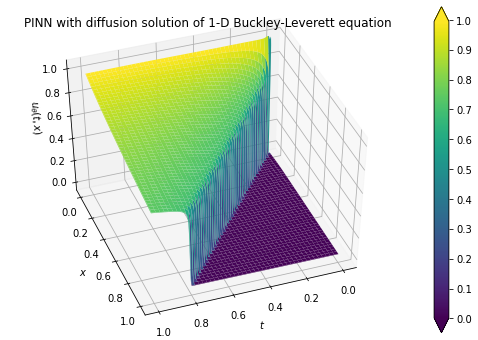

In [269]:
upred_diff = model_diff(tf.cast(Xgrid,DTYPE))
U_diff = upred_diff.numpy().reshape(N+1,N+1) # Reshape upred
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.plot_surface(T, X, U_diff, cmap='viridis')
ax.view_init(45,70) # view angle
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_zlim(-0.05,1.05)
ax.set_title('PINN with diffusion solution of 1-D Buckley-Leverett equation')
plt.colorbar(p, ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], extend='both');

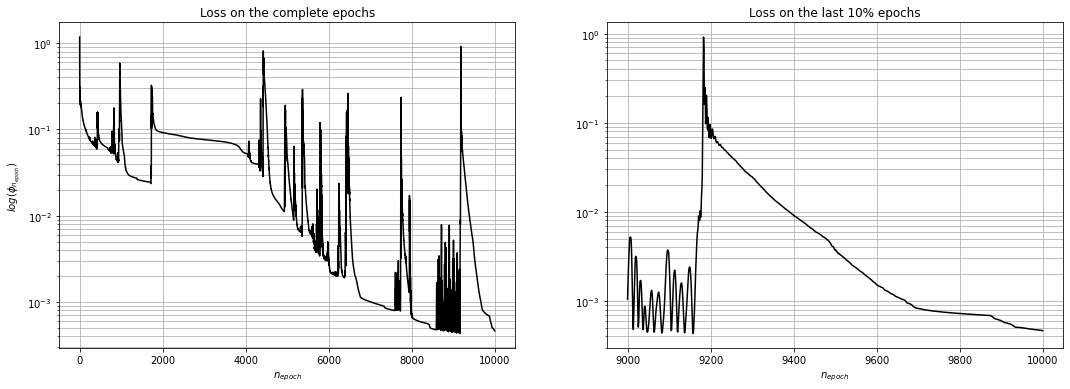

In [268]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(121) # complete plot
ax.semilogy(range(len(hist_diff)), hist_diff,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$log(\\phi_{n_{epoch}})$')
plt.grid(True, which ="both")
plt.title('Loss on the complete epochs')
ax = fig.add_subplot(122) # last 90%
N_epoch_90 = round(0.9*N_epoch)
hist90_diff = hist_diff[N_epoch_90:N_epoch]
ax.semilogy(np.arange(N_epoch_90,N_epoch), hist90_diff,'k-')
ax.set_xlabel('$n_{epoch}$')
plt.grid(True, which ="both")
plt.title('Loss on the last 10% epochs');

### 3.4) Comparison between the PINN with diffusive term solution and the analytical solution

Again, for comparison porpuse, the curves of the PINN solution with diffusion at the instants 0.25, 0.5 and 0.75:

In [270]:
u1_PINN_diff = U_diff[:,pt1]
u2_PINN_diff = U_diff[:,pt2]
u3_PINN_diff = U_diff[:,pt3]

Ploting both at the instants 0.25, 0.5 and 0.75:

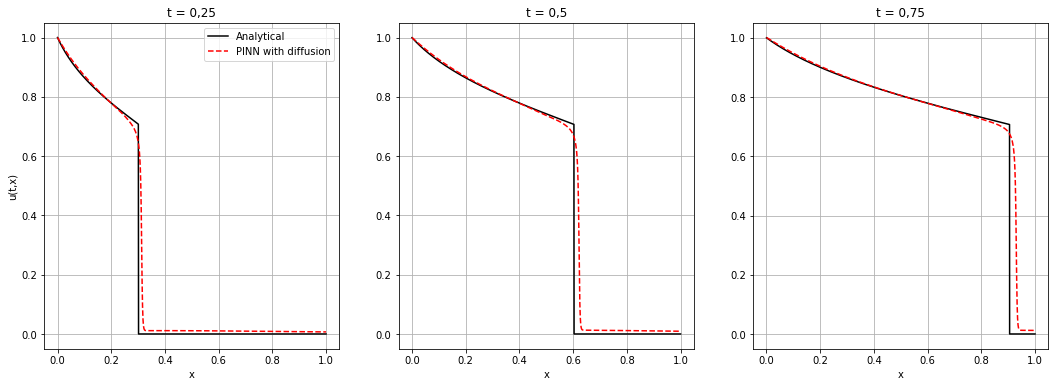

In [271]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(x1, u1, 'k', label='Analytical')
plt.plot(xspace, u1_PINN_diff, 'r--', label='PINN with diffusion')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('t = 0,25')
plt.legend()
plt.grid(True)

plt.subplot(132)
plt.plot(x2, u2, 'k')
plt.plot(xspace, u2_PINN_diff, 'r--')
plt.xlabel('x')
plt.title('t = 0,5')
plt.grid(True)

plt.subplot(133)
plt.plot(x3, u3, 'k')
plt.plot(xspace, u3_PINN_diff, 'r--')
plt.xlabel('x')
plt.title('t = 0,75')
plt.grid(True)

plt.show();

From these results, we see that adding a diffusion term to the conservation equation allows the neural network to capture better the location of the saturation, altough there is a smoothing of the shock because the effects of diffusion.